In [1]:
import os

import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

# utility for plotting
plt_color = ((0.1, 0.2, 1, 0.6))

# Let's Build our Foundational Dataset
Hello and welcome! Here are some key bullet points in understanding our data:
1. We have six .csv files all containing varieties of the same data
2. This data has been collected on a country by country basis
3. Each .csv corresponds to the data from one particular year
4. The features given are scores on some arbitrary scale
5. Happiness score of a country is determined by these features
6. Lets check it out!

In [2]:
# our data consists of 6 .csv files
# we store them as individual dataframes

master_df = []
for i in range(2015, 2020 + 1):
    path = '1 World_happiness_report_data/' + str(i) + '.csv'
    master_df.append(pd.read_csv(path))

In [3]:
# what does all this data look like? Let's check out our feature space

for i in range(len(master_df)):
    print("df",i,":\t", len(master_df[i].columns), "features")

df 0 :	 12 features
df 1 :	 13 features
df 2 :	 12 features
df 3 :	 9 features
df 4 :	 9 features
df 5 :	 20 features


In [4]:
# Hmm these dfs have varying features, Lets take a closer look

for i in range(len(master_df)):
    local_features = [master_df[i].columns[j] for j in range(len(master_df[i].columns))]
    
    print("Year", 2015+i)
    print("." * 135)
    print(local_features, "\n\n")

Year 2015
.......................................................................................................................................
['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Standard Error', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual'] 


Year 2016
.......................................................................................................................................
['Country', 'Region', 'Happiness Rank', 'Happiness Score', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual'] 


Year 2017
.......................................................................................................................................
['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high', 'Whiske

In [5]:
def normalize(data):
    """normalizes 1d array to be within range [0,1]
    """
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
# since our data is reported from multiple studies it is important that we 
# normalize our features so that our features are consistant across datasets

for i in range(len(master_df)):
    for col in master_df[i].columns:
        if master_df[i][col].dtypes != "object":
            master_df[i][col] = normalize(master_df[i][col])

In [7]:
# We want to match up the features for all of our dfs
# here are the first four features for each

for i in range(len(master_df)):
    print(i, master_df[i].columns[0:4].values)

0 ['Country' 'Region' 'Happiness Rank' 'Happiness Score']
1 ['Country' 'Region' 'Happiness Rank' 'Happiness Score']
2 ['Country' 'Happiness.Rank' 'Happiness.Score' 'Whisker.high']
3 ['Overall rank' 'Country or region' 'Score' 'GDP per capita']
4 ['Overall rank' 'Country or region' 'Score' 'GDP per capita']
5 ['Country name' 'Regional indicator' 'Ladder score'
 'Standard error of ladder score']


In [8]:
# Country seems to be the first common feature for our datasets
# This feature will be used as our lookup index later on
# We can start by rearranging df[3, 4] to get this feature upfront

master_df[3] = master_df[3][['Country or region','Overall rank', 'Score', 'GDP per capita',
                           'Social support', 'Healthy life expectancy',
                           'Freedom to make life choices', 'Generosity',
                           'Perceptions of corruption']]

master_df[4] = master_df[4][['Country or region', 'Overall rank', 'Score', 'GDP per capita',
                           'Social support', 'Healthy life expectancy',
                           'Freedom to make life choices', 'Generosity',
                           'Perceptions of corruption']]

In [9]:
# next we can rename df[3, 4, 5] to 'country'

master_df[3].rename(columns={'Country or region': 'Country'}, inplace=True)
master_df[4].rename(columns={'Country or region': 'Country'}, inplace=True)
master_df[5].rename(columns={'Country name': 'Country'}, inplace=True)

In [10]:
# now lets make sure this fisrt feature matches up for all dfs

for i in range(len(master_df)):
    print(i, master_df[i].columns[0:3].values)

0 ['Country' 'Region' 'Happiness Rank']
1 ['Country' 'Region' 'Happiness Rank']
2 ['Country' 'Happiness.Rank' 'Happiness.Score']
3 ['Country' 'Overall rank' 'Score']
4 ['Country' 'Overall rank' 'Score']
5 ['Country' 'Regional indicator' 'Ladder score']


In [11]:
# Our next common feature is happiness
# This happiness value is a score and will eventually be our dependent variable

happiness_feature = "Happiness"

In [12]:
master_df[0].drop(['Region', 'Happiness Rank'], axis=1, inplace=True)
master_df[0].rename(columns={'Happiness Score': happiness_feature}, inplace=True)

In [13]:
master_df[1].drop(['Region', 'Happiness Rank'], axis=1, inplace=True)
master_df[1].rename(columns={'Happiness Score': happiness_feature}, inplace=True)

In [14]:
master_df[2].drop(['Happiness.Rank'], axis=1, inplace=True)
master_df[2].rename(columns={'Happiness.Score': happiness_feature}, inplace=True)

In [15]:
master_df[3].drop(['Overall rank'], axis=1, inplace=True)
master_df[3].rename(columns={'Score': happiness_feature}, inplace=True)

In [16]:
master_df[4].drop(['Overall rank'], axis=1, inplace=True)
master_df[4].rename(columns={'Score': happiness_feature}, inplace=True)

In [17]:
master_df[5].drop(['Regional indicator'], axis=1, inplace=True)
master_df[5].rename(columns={'Ladder score': happiness_feature}, inplace=True)

In [18]:
# How do our first few features across our dfs look now?

for i in range(len(master_df)):
    print(i, master_df[i].columns[0:3].values)

0 ['Country' 'Happiness' 'Standard Error']
1 ['Country' 'Happiness' 'Lower Confidence Interval']
2 ['Country' 'Happiness' 'Whisker.high']
3 ['Country' 'Happiness' 'GDP per capita']
4 ['Country' 'Happiness' 'GDP per capita']
5 ['Country' 'Happiness' 'Standard error of ladder score']


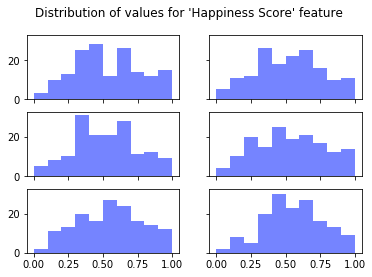

In [19]:
# We can check that this Happiness feature is the same on all of
# our datasets by comparing the distribution of each

fig, axs = plt.subplots(3,2, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Happiness Score\' feature')
for i in range(6):
    axs[i % 3, i % 2].hist(master_df[i]["Happiness"], color=plt_color)

In [20]:
# Happiness checks out.
# Next we will look at our third common feature: GDP

GDP_feature = "GDP"

In [21]:
master_df[0].drop(['Standard Error'], axis=1, inplace=True)
master_df[0].rename(columns={'Economy (GDP per Capita)': GDP_feature}, inplace=True)

In [22]:
master_df[1].drop(['Lower Confidence Interval', 'Upper Confidence Interval'],  axis=1, inplace=True)
master_df[1].rename(columns={'Economy (GDP per Capita)': GDP_feature}, inplace=True)

In [23]:
master_df[2].drop(['Whisker.high', 'Whisker.low'], axis=1, inplace=True)
master_df[2].rename(columns={'Economy..GDP.per.Capita.': GDP_feature}, inplace=True)

In [24]:
master_df[3].rename(columns={'GDP per capita': GDP_feature}, inplace=True)

In [25]:
master_df[4].rename(columns={'GDP per capita': GDP_feature}, inplace=True)

In [26]:
master_df[5].drop(['Standard error of ladder score','upperwhisker', 'lowerwhisker'], axis=1, inplace=True)
master_df[5].rename(columns={'Logged GDP per capita': GDP_feature}, inplace=True)

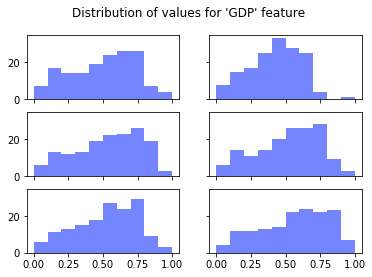

In [27]:
# Again, just to be careful, lets make sure that this GDP score
# is identically distributed for all datasets in use

fig, axs = plt.subplots(3,2, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'GDP\' feature')
for i in range(6):
    axs[i % 3, i % 2].hist(master_df[i]["GDP"], color=plt_color)

In [28]:
# Now our first few features are all matched up throughout our dfs

for i in range(len(master_df)):
    print(i, master_df[i].columns[0:3].values)

0 ['Country' 'Happiness' 'GDP']
1 ['Country' 'Happiness' 'GDP']
2 ['Country' 'Happiness' 'GDP']
3 ['Country' 'Happiness' 'GDP']
4 ['Country' 'Happiness' 'GDP']
5 ['Country' 'Happiness' 'GDP']


In [29]:
# The next set of features:

for i in range(len(master_df)):
    print(i, master_df[i].columns[3:6].values)

0 ['Family' 'Health (Life Expectancy)' 'Freedom']
1 ['Family' 'Health (Life Expectancy)' 'Freedom']
2 ['Family' 'Health..Life.Expectancy.' 'Freedom']
3 ['Social support' 'Healthy life expectancy' 'Freedom to make life choices']
4 ['Social support' 'Healthy life expectancy' 'Freedom to make life choices']
5 ['Social support' 'Healthy life expectancy' 'Freedom to make life choices']


In [30]:
"""It seems that all of our datasets of these two features 'Family'
and 'Social support' up next. These features sound like they may
have the same underlying distribution. In order to verify this
hypothesis we will plot their distributions below.

Disclaimer: I am aware that their are statistical tests to prove 
such equality/inequality. I am still building on my statistical 
toolbelt and I do not feel comfortable with such tools yet. I do
not want to use a stats tool that I do not fully understand, and
so I chose a more simple and naive approach. Please feel free to 
give me feedback on this thought :-)
"""

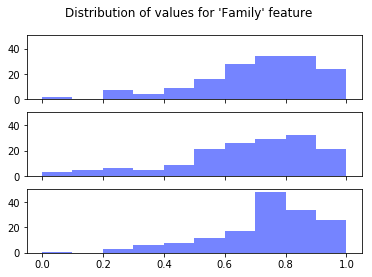

In [31]:
# first lets grab dfs[0, 1, 2] and analyze whats going on with 
# this data and more specifically the 'Family' feature

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Family\' feature')

for i in range(3):
    axs[i].hist(master_df[i]["Family"], color=plt_color)

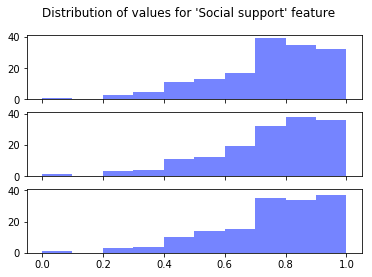

In [32]:
# Next, we can analyze the 'Social support' feature and check to
# see if its distribution matches that of the 'Family' feature

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Social support\' feature')

for i in range(3,6):
    axs[i - 3].hist(master_df[i]["Social support"], color=plt_color)

In [33]:
# I think it is reasonable to make the claim that these features
# come from the same distribution.

for i in range(3, 6):
    master_df[i].rename(columns={"Social support": "Family"}, inplace=True)

In [34]:
# our family feature is complete

for i in range(len(master_df)):
    print(i, master_df[i].columns[3:6].values)

0 ['Family' 'Health (Life Expectancy)' 'Freedom']
1 ['Family' 'Health (Life Expectancy)' 'Freedom']
2 ['Family' 'Health..Life.Expectancy.' 'Freedom']
3 ['Family' 'Healthy life expectancy' 'Freedom to make life choices']
4 ['Family' 'Healthy life expectancy' 'Freedom to make life choices']
5 ['Family' 'Healthy life expectancy' 'Freedom to make life choices']


In [35]:
# The next feature, 'Health', is an easy one
# All we have to do here is change the column name

health_feature = "Health"
master_df[0].rename(columns={"Health (Life Expectancy)": health_feature}, inplace=True)
master_df[1].rename(columns={"Health (Life Expectancy)": health_feature}, inplace=True)
master_df[2].rename(columns={"Health..Life.Expectancy.": health_feature}, inplace=True)
master_df[3].rename(columns={"Healthy life expectancy": health_feature}, inplace=True)
master_df[4].rename(columns={"Healthy life expectancy": health_feature}, inplace=True)
master_df[5].rename(columns={"Healthy life expectancy": health_feature}, inplace=True)

In [36]:
""" Our next feature seems to have two different names throuhgout
our datasets, 'Freedom' and 'Freedom to make life choices'. We will
do the same "test" of equal distributions on this feature that we 
did on the "Family" feature.
"""

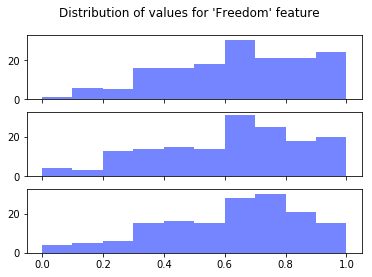

In [37]:
# dfs[0, 1, 2] all have the 'Freedom' feature

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Freedom\' feature')

for i in range(3):
    axs[i].hist(master_df[i]["Freedom"], color=plt_color)

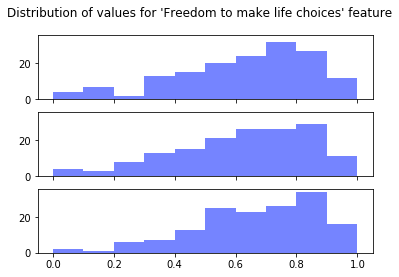

In [38]:
# dfs[3, 4, 5] all have the 'Freedom to make life choices' feature

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Freedom to make life choices\' feature')

for i in range(3,6):
    axs[i - 3].hist(master_df[i]["Freedom to make life choices"], color=plt_color)

In [39]:
# I will make the claim that these are identical.

for i in range(3, 6):
    master_df[i].rename(columns={"Freedom to make life choices": "Freedom"}, inplace=True)

In [40]:
# Here is what our columns[3:6] for each df look like

for i in range(len(master_df)):
    print(i, master_df[i].columns[3:6].values)

0 ['Family' 'Health' 'Freedom']
1 ['Family' 'Health' 'Freedom']
2 ['Family' 'Health' 'Freedom']
3 ['Family' 'Health' 'Freedom']
4 ['Family' 'Health' 'Freedom']
5 ['Family' 'Health' 'Freedom']


In [41]:
# Now we have two more similar features

for i in range(len(master_df)):
    print(i, master_df[i].columns[6:8].values)

0 ['Trust (Government Corruption)' 'Generosity']
1 ['Trust (Government Corruption)' 'Generosity']
2 ['Generosity' 'Trust..Government.Corruption.']
3 ['Generosity' 'Perceptions of corruption']
4 ['Generosity' 'Perceptions of corruption']
5 ['Generosity' 'Perceptions of corruption']


In [42]:
# df[0, 1]'s columns need reordering to have a uniform Generosity feature

master_df[0].columns = ['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom',
       'Generosity', 'Trust (Government Corruption)', 'Dystopia Residual']

master_df[1].columns = ['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom',
       'Generosity', 'Trust (Government Corruption)', 'Dystopia Residual']

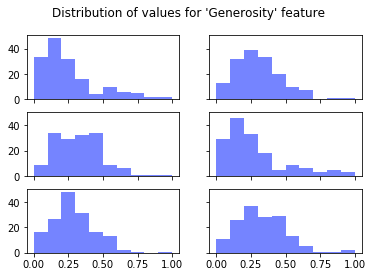

In [43]:
# lets make sure that this 'Generosity' is identically distributed for all dfs

fig, axs = plt.subplots(3,2, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Generosity\' feature')
for i in range(6):
    axs[i % 3, i % 2].hist(master_df[i]["Generosity"], color=plt_color)

In [44]:
# That was easy!

for i in range(len(master_df)):
    print(i, master_df[i].columns[6:8].values)

0 ['Generosity' 'Trust (Government Corruption)']
1 ['Generosity' 'Trust (Government Corruption)']
2 ['Generosity' 'Trust..Government.Corruption.']
3 ['Generosity' 'Perceptions of corruption']
4 ['Generosity' 'Perceptions of corruption']
5 ['Generosity' 'Perceptions of corruption']


(array([30., 52., 29., 16.,  3.,  8.,  9.,  1.,  4.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

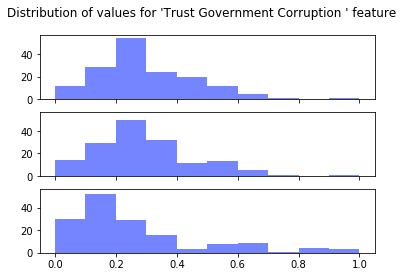

In [45]:
# Again lets do the same thing for "Trust Governement Corruption"

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Trust Government Corruption \' feature')

for i in range(2):
    axs[i].hist(master_df[i]["Trust (Government Corruption)"], color=plt_color)
axs[2].hist(master_df[2]["Trust..Government.Corruption."], color=plt_color)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


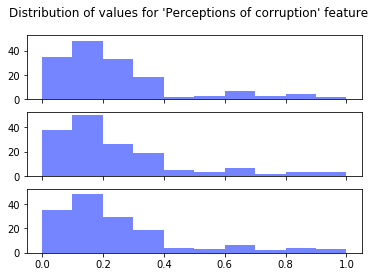

In [46]:
# VS the distribution of "Perceptions of corruption"

master_df[5]["Perceptions of corruption"] = 1 - master_df[5]["Perceptions of corruption"]

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Distribution of values for \'Perceptions of corruption\' feature')

for i in range(3,6):
    axs[i - 3].hist(master_df[i]["Perceptions of corruption"], color=plt_color)

In [47]:
# Looks good to me, Lets update this column name

trust_gov_feature = "Trust_gov"
master_df[0].rename(columns={"Trust (Government Corruption)": trust_gov_feature}, inplace=True)
master_df[1].rename(columns={"Trust (Government Corruption)": trust_gov_feature}, inplace=True)
master_df[2].rename(columns={"Trust..Government.Corruption.": trust_gov_feature}, inplace=True)
master_df[3].rename(columns={"Perceptions of corruption": trust_gov_feature}, inplace=True)
master_df[4].rename(columns={"Perceptions of corruption": trust_gov_feature}, inplace=True)
master_df[5].rename(columns={"Perceptions of corruption": trust_gov_feature}, inplace=True)

In [48]:
# Lets see what kind of features we have next

for i in range(len(master_df)):
    print(i, master_df[i].columns[8:16].values)

0 ['Dystopia Residual']
1 ['Dystopia Residual']
2 ['Dystopia.Residual']
3 []
4 []
5 ['Ladder score in Dystopia' 'Explained by: Log GDP per capita'
 'Explained by: Social support' 'Explained by: Healthy life expectancy'
 'Explained by: Freedom to make life choices' 'Explained by: Generosity'
 'Explained by: Perceptions of corruption' 'Dystopia + residual']


In [49]:
# Uh oh! it looks like we have hit the end of our features for two of our dfs
# Since we ant uniform features throughout our data, we can only use as many
# features as our smallest featurespace gives us

# Prepare the Master Data
Our dataframes seem to match (for now). So next we will be putting all this data together. There are a few key practices and measure that need to be taken to ensure our data is of good quality. 

In [50]:
# Lets drop all features in our data except for the eight features included
# in all of our dfs (outlined above)

master_features = ['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom', 'Generosity', 'Trust_gov']
for i in range(len(master_df)):
    for col in master_df[i].columns:
        if col not in master_features:
            master_df[i].drop(col, axis=1, inplace=True)

In [51]:
# Now lets see what our data's features look like

for i in range(len(master_df)):
    print("Year", 2015+i)
    print("." * 100)
    print([master_df[i].columns[j] for j in range(len(master_df[i].columns))], "\n\n")

Year 2015
....................................................................................................
['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom', 'Generosity', 'Trust_gov'] 


Year 2016
....................................................................................................
['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom', 'Generosity', 'Trust_gov'] 


Year 2017
....................................................................................................
['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom', 'Generosity', 'Trust_gov'] 


Year 2018
....................................................................................................
['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom', 'Generosity', 'Trust_gov'] 


Year 2019
....................................................................................................
['Country', 'Happiness', 'GDP', 'Family', 'Health', 'Freedom', 'Generosit

In [52]:
"""Awesome, our data has uniform features. Now that we are done with this basic
feature engineering, what do we do next? So since our dfs are all split by year (ie 
df[0] if from 2015, df[1] is from 2016, etc.) lets add a year column. This will
enable us to have a distrinction from row 'a' to row 'b' of any given country
"""

In [53]:
# lets append the year

for i in range(len(master_df)):
    master_df[i]['Year'] = 2015 + i

# Now we can merge the datasets
# and set 'Country' as our index

df = pd.concat(master_df)
df.index = df['Country']
df.drop(['Country'], axis=1, inplace=True)

In [54]:
# Cool, our many dfs have been merged into the master df!

display(df.head())
display(df.tail())

,Happiness,GDP,Family,Health,Freedom,Generosity,Trust_gov,Year
Country,,,,,,,,
Switzerland,1.000000,0.826132,0.962403,0.918244,0.993789,0.760595,0.372895,2015
Iceland,0.994524,0.770412,1.000000,0.924496,0.938841,0.256292,0.548198,2015
Denmark,0.987363,0.784113,0.970297,0.853099,0.969615,0.876175,0.428947,2015
Norway,0.986310,0.863099,0.949167,0.863409,1.000000,0.661394,0.435983,2015
Canada,0.966302,0.784592,0.943219,0.883326,0.945112,0.597144,0.575602,2015


,Happiness,GDP,Family,Health,Freedom,Generosity,Trust_gov,Year
Country,,,,,,,,
Central African Republic,0.173414,0.026728,0.000000,0.000000,0.422367,0.444905,0.053013,2020
Rwanda,0.142203,0.223367,0.337870,0.503055,0.871360,0.413653,0.910684,2020
Zimbabwe,0.139704,0.276938,0.677085,0.329612,0.544383,0.265612,0.151790,2020
South Sudan,0.047636,0.188122,0.357515,0.183518,0.094637,0.368427,0.208486,2020
Afghanistan,0.000000,0.195686,0.230319,0.233827,0.000000,0.237331,0.002299,2020


In [55]:
"""One big problem that needs to be acknowledged is the differences of naming
conventions from year 'i' to year 'j'. If our data was perfect (which it is not,
nor will data every be perfect in the real world) then all countries would have
the same names in each dataset, and therefore each country name would be counted
for 6 times.
"""

In [56]:
def abnormal_country_counts(df):
    """First lets get all the country names
    Initialize dict to zero counts for each country
    Increment country count for all countries in df
    If the count is not equal to 6, further examination is needed
    """
    country_indexes = sorted(df.index.values)
    country_dict = {}

    for country in np.unique(country_indexes):
        country_dict[country] = 0
    
    for country in country_indexes:
        country_dict[country] += 1

    for country in country_dict:
        if country_dict[country] != 6:
            print(country, country_dict[country])

In [57]:
# lets see which countries are missmatched/ undercounted

abnormal_country_counts(df)

Angola 4
Belize 3
Bhutan 5
Central African Republic 5
Comoros 4
Djibouti 1
Gambia 2
Hong Kong 4
Hong Kong S.A.R. of China 1
Hong Kong S.A.R., China 1
Laos 5
Lesotho 5
Macedonia 5
Maldives 1
Mozambique 5
Namibia 5
North Cyprus 4
North Macedonia 1
Northern Cyprus 2
Oman 1
Puerto Rico 1
Qatar 5
Somalia 4
Somaliland Region 1
Somaliland region 1
South Sudan 5
Sudan 4
Suriname 2
Swaziland 3
Syria 5
Taiwan 4
Taiwan Province of China 2
Trinidad & Tobago 2
Trinidad and Tobago 4


In [58]:
# as it turns out, some countries are misnamed from year to year
# the following lines were hand picked to fulfill this desired name match

df.rename(index={"Hong Kong S.A.R. of China" : "Hong Kong"}, inplace=True)
df.rename(index={"Hong Kong S.A.R., China" : "Hong Kong"}, inplace=True)
df.rename(index={"Northern Cyprus" : "North Cyprus"}, inplace=True)
df.rename(index={"Macedonia" : "North Macedonia"}, inplace=True)
df.rename(index={"Taiwan Province of China" : "Taiwan"}, inplace=True)
df.rename(index={"Trinidad & Tobago" : "Trinidad and Tobago"}, inplace=True)
df.rename(index={'Somaliland region':'Somaliland Region'},inplace=True)

In [59]:
# Any country not included in the above block simply seems to be underrepresented
# Lets see the remaining countries and their associated count

abnormal_country_counts(df)

Angola 4
Belize 3
Bhutan 5
Central African Republic 5
Comoros 4
Djibouti 1
Gambia 2
Laos 5
Lesotho 5
Maldives 1
Mozambique 5
Namibia 5
Oman 1
Puerto Rico 1
Qatar 5
Somalia 4
Somaliland Region 2
South Sudan 5
Sudan 4
Suriname 2
Swaziland 3
Syria 5


In [60]:
"""If we want to model our data, there cannot be any NAN values. It is very
common for data to either come with NANs or to have NANs produced during
your data exploration/manipulation.
"""

In [61]:
# if there are NANs, where are they?

np.where(np.isnan(df.values))

(array([489], dtype=int64), array([6], dtype=int64))

In [62]:
# Turns out we have one NAN within our UAE data

df.loc["United Arab Emirates"][["Trust_gov", "Year"]]

,Trust_gov,Year
Country,,
United Arab Emirates,0.332060,2015
United Arab Emirates,0.324395,2016
United Arab Emirates,0.698867,2017
United Arab Emirates,NaN,2018
United Arab Emirates,0.401766,2019
United Arab Emirates,0.413033,2020


In [63]:
# This looks like a lot of confusing code but what we are doing is actually very simple:
# Lets take the average of "Trust_gov" for all years (not NAN values) collected from
# UAE only. 

# Alternatively, we could drop the NAN row, but I chose this approach because it seemed 
# like an opportunity to do some cool pandas manipulation.

UAE_trust_values = df.loc["United Arab Emirates"]["Trust_gov"].values
mean_UAE_trust_value = np.mean(UAE_trust_values[np.where(1 - np.isnan(UAE_trust_values))])
df.iloc[np.where(np.isnan(df))] = mean_UAE_trust_value

In [64]:
# goodbye NANs

df.loc["United Arab Emirates"][["Trust_gov", "Year"]]

,Trust_gov,Year
Country,,
United Arab Emirates,0.332060,2015
United Arab Emirates,0.324395,2016
United Arab Emirates,0.698867,2017
United Arab Emirates,0.434024,2018
United Arab Emirates,0.401766,2019
United Arab Emirates,0.413033,2020


# Export Data
Data is the new oil (they say)! Let's save our new, clean data.

In [65]:
# here is what our data looks like now

df.head()

,Happiness,GDP,Family,Health,Freedom,Generosity,Trust_gov,Year
Country,,,,,,,,
Switzerland,1.000000,0.826132,0.962403,0.918244,0.993789,0.760595,0.372895,2015
Iceland,0.994524,0.770412,1.000000,0.924496,0.938841,0.256292,0.548198,2015
Denmark,0.987363,0.784113,0.970297,0.853099,0.969615,0.876175,0.428947,2015
Norway,0.986310,0.863099,0.949167,0.863409,1.000000,0.661394,0.435983,2015
Canada,0.966302,0.784592,0.943219,0.883326,0.945112,0.597144,0.575602,2015


In [67]:
# saved as a .csv

df.to_csv('1 World_happiness_report_data/world_happiness_report.csv')

In [68]:
# and if we read it back in, it seems that we have no issues

pd.read_csv('1 World_happiness_report_data/world_happiness_report.csv', index_col="Country").head()

,Happiness,GDP,Family,Health,Freedom,Generosity,Trust_gov,Year
Country,,,,,,,,
Switzerland,1.000000,0.826132,0.962403,0.918244,0.993789,0.760595,0.372895,2015
Iceland,0.994524,0.770412,1.000000,0.924496,0.938841,0.256292,0.548198,2015
Denmark,0.987363,0.784113,0.970297,0.853099,0.969615,0.876175,0.428947,2015
Norway,0.986310,0.863099,0.949167,0.863409,1.000000,0.661394,0.435983,2015
Canada,0.966302,0.784592,0.943219,0.883326,0.945112,0.597144,0.575602,2015


# Regression
It is time to model our data. In this notebook, I want to focus on interpreting our data. Rather than doing the classic train-test split, lets do a simple linear regression model. The goal here is to analyze the relationship between our dependent (Happiness) and independent (features) variables. 

In [69]:
# lets copy our df and drop year

df_copy = np.copy(df.values)
df.drop(["Year"], axis=1, inplace=True)

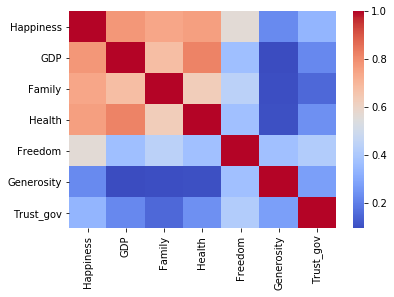

In [70]:
# Here is the correlation matrix amoung our featurespace
# You can interpret this at the "similarity of movement" that two features 
# exress if plotted or paired together

sns.heatmap(df.corr(), cmap="coolwarm")
plt.plot();

In [71]:
# Now lets seperate our model inputs vs target values

dependent_var = df["Happiness"]
independent_var = df.drop(["Happiness"], axis=1)

In [72]:
# first we can train a scikit learn linear regression model

sklearn_model = linear_model.LinearRegression()
sklearn_model.fit(independent_var, dependent_var)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
# then we can train a statsmodel ordinary leastsquares model

ind_var_const = sm.add_constant(independent_var)
stats_model_obj = sm.OLS(dependent_var, ind_var_const)
stats_model = stats_model_obj.fit()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [74]:
# Lets see how the resulting regression coefficients compare from sklearn's
# LinearRegression to stats models OLS. In theory these two models should
# produce identical results

sklearn_coef = sklearn_model.coef_
print(format("", '10'),"sklearn", format("", '1'), "statsmodels")
print(format("const",'9'), format(sklearn_model.intercept_,'.6f'), format(stats_model.params[0], ".6f"))
for i in range(len(sklearn_coef)):
    print(format(independent_var.columns[i],'10'), format(sklearn_coef[i], '.6f'), "" ,
          format(stats_model.params[i + 1], '.6f'))

           sklearn   statsmodels
const     -0.181335 -0.181335
GDP        0.287554  0.287554
Family     0.351729  0.351729
Health     0.245950  0.245950
Freedom    0.196730  0.196730
Generosity 0.069147  0.069147
Trust_gov  0.085106  0.085106


In [75]:
# The coolest feature of Statsmodels.OLS is it's summary statistics
# As shown below, in a one word command, we can access key analytics
# of regression like R^2, and p-values.

stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Happiness   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     522.2
Date:                Sat, 08 Aug 2020   Prob (F-statistic):          2.22e-293
Time:                        13:30:38   Log-Likelihood:                 726.11
No. Observations:                 935   AIC:                            -1438.
Df Residuals:                     928   BIC:                            -1404.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1813      0.016    -11.687      0.000      -0.212      -0.151
GDP            0.2876      0.030      9.611      0.000       0.229       0.346
Family         0.3517      0.027     12.911      0.000       0.298       0.405
Health         0.2460      0.028      8.840      0.000       0.191       0.301
Freedom        0.1967      0.021      9.525      0.000       0.156       0.237
Generosity     0.0691      0.021      3.255      0.001       0.027       0.111
Trust_gov      0.0851      0.021      4.087      0.000       0.044       0.126
==============================================================================
Omnibus:                       19.113   Durbin-Watson:                   1.527
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.237
Skew:                          -0.294   Prob(JB):                     2.45e-05
Kurtosis:                       3.447   Cond. No.                         17.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# Woah! all of our features are statistically significant.
# Lets rank our features in order of importance

print("i", format("Feature", '10'), "Weight")
print("-" * 20)

sorted_coefs = np.sort(np.array(stats_model.params))
for i in range(len(stats_model.params)):
    if i > 0:
        ith_sorted_val = sorted_coefs[-i]
        position = np.where(stats_model.params == ith_sorted_val)[0][0]
        print(i, format(independent_var.columns[i - 1], '10'), format(ith_sorted_val, '.4f'))

i Feature    Weight
--------------------
1 GDP        0.3517
2 Family     0.2876
3 Health     0.2460
4 Freedom    0.1967
5 Generosity 0.0851
6 Trust_gov  0.0691


In [77]:
# So, GDP and Family are the biggest indicators of happiness while
# Generosity and Trust of Government are the smallest indeicators of
# happiness (on a country basis)

# We will be adding more features, doing more modeling in notebooks to
# come. So either check them out if they are already posted, or stay tuned